In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Pairwise Cluster Comparisons - FINAL.txt", sep="\t")

In [3]:
# Normalize all sequences to 22 nt - Median length of miRNA in the database
# see notebook "2.10.3 Degree of complementarity at position 9-22 for seed-homologous miRNA.ipnyb"
def normalize_seq(seq, length=22):
    seq = seq.upper()
    if len(seq) >= length:
        return seq[:length]
    else:
        return seq + 'N' * (length - len(seq))

In [4]:
df["NormSeq1"] = df["Sequence_miRNA1"].apply(normalize_seq)
df["NormSeq2"] = df["Sequence_miRNA2"].apply(normalize_seq)

In [5]:
def match_vector(s1, s2):
    return [1 if a == b else 0 for a, b in zip(s1, s2)]

match_vectors = df.apply(lambda row: match_vector(row["NormSeq1"], row["NormSeq2"]), axis=1)

In [6]:
# Create sliding window features (4-mer windows from positions 1–4 to 19–22)
def extract_windows(match_vec, window_size=4):
    return [sum(match_vec[i:i + window_size]) for i in range(len(match_vec) - window_size + 1)]

window_features = match_vectors.apply(extract_windows)
window_df = pd.DataFrame(window_features.tolist(), columns=[f"match_{i+1}_{i+4}" for i in range(19)])

In [8]:
X = window_df
y = df["Jaccard"]

In [9]:
# Train/test split - 20 % of the dataset for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train XGBoost regressor
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict(X_test)
print("R² on test set:", round(r2_score(y_test, y_pred), 4))

R² on test set: 0.0102


In [14]:
# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [16]:
# Compute smoothed positional importance (1D heatmap over sequence)
shap_importance = np.abs(shap_values.values).mean(axis=0)
pos_scores = np.zeros(22)
counts = np.zeros(22)

for name, val in zip(X.columns, shap_importance):
    start, end = map(int, name.replace("match_", "").split("_"))
    for i in range(start - 1, end):
        pos_scores[i] += val
        counts[i] += 1

avg_importance = np.divide(pos_scores, counts, out=np.zeros_like(pos_scores), where=counts != 0)

Save plot as PNG? (yes/no):  yes


Plot saved as shap_importance.png


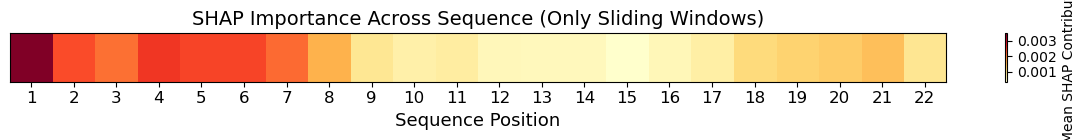

In [27]:
plt.figure(figsize=(12, 1.5))
plt.imshow([avg_importance], cmap="YlOrRd", aspect="auto")
plt.xticks(ticks=np.arange(22), labels=np.arange(1, 23), fontsize=12)
plt.yticks([])
plt.xlabel("Sequence Position", fontsize=13)
plt.title("SHAP Importance Across Sequence (Only Sliding Windows)", fontsize=14)
plt.colorbar(label="Mean SHAP Contribution")
plt.tight_layout()

save = input("Save plot as PNG? (yes/no): ").strip().lower()
if save == 'yes':
    plt.savefig("shap_importance.png", dpi=300, bbox_inches='tight')
    print("Plot saved as shap_importance.png")

plt.show()